In [170]:
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import psycopg2 as pg
import pandas as pd

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
class DatabaseConnection:
    def __init__(self):
        self.conn = self.connect()
    def connect(self):
        try:
            self.conn = pg.connect(
                "dbname='stonksdb' user='postgres' host='localhost' password='admin'")
            print("Connection made succ")
            return self.conn
        except:
            print("I am unable to connect to the database")
            return None
    def close(self):
        self.conn.close()
    
    def GetConnector(self):
        return self.conn
    ### send query to database
    def query(self, query):
        cur = self.conn.cursor()
        cur.execute(query)
        return cur.fetchall()

class DatasetAccess:
    def __init__(self):
        self.conn = DatabaseConnection()
    def getNcompanies(self, N):
        AllCompanies = self.conn.query("SELECT * FROM dataset limit "+ str(N)+"")
        return AllCompanies
    def getStockFromSymbol(self, StockSymbol, column = '*'):
        company = self.conn.query("SELECT * FROM dataset WHERE symbol = '" + StockSymbol + "'")
        self.getStockFromCompany(company, column)
        return company
    def getStockFromCompany(self, companies, column = '*'):
        result = []
        for company in companies:
            result.append(self.conn.query("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "'"))
        return result
    def convertListToString(self, column):
        if type(column) != list:
            return column
        result = ''
        for item in column:
            result += item + ', '
        return result[:-2]
    def getStockDFFromCompany(self, companies, column = '*'):
        result = []
        print(companies)
        for company in companies:
            result.append(pd.read_sql("SELECT "+self.convertListToString(column)+" FROM stock WHERE identifier = '" + str(company[0]) + "' order by time asc", self.conn.GetConnector()))
        return result
    def GetAllStocksAsDF(self):
        PandaStock = pd.read_sql('SELECT * FROM stock', self.conn.GetConnector())
        print(PandaStock)
    
def GetDF():
    dbaccess = DatasetAccess()
    vestas = pd.read_sql("select * from stock where identifier = 15611 ", dbaccess.conn.GetConnector())
    return vestas

def GetSingleStockDF():
    dbAccess = DatasetAccess()
    comp = dbAccess.getNcompanies(2)
    return dbAccess.getStockDFFromCompany(comp, column="close")

In [25]:
def make_batch():
    replica_input = train
    replica_input = [np.array(replica_input)]
    replica_Input = [n for n in replica_input[0]]
    print("____________-")
    replica_output = train
    replica_output = [np.array(replica_output)]
    replica_Output = [n for n in replica_output[0]]
    print("____________-")
    replica_target = target
    replica_target = [np.array(replica_target)]
    replica_Target = [n for n in replica_target[0]]
    
    #input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]] # takes the number and one hot encodes it
    #print(input_batch)
    #print(replica_Output)
    #output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]] # takes the number and one hot encodes it
    #target_batch = [[word_dict[n] for n in sentences[2].split()]] # takes the number
    # print(input_batch)
    # print([np.array([replica_input])])
    # make tensor
    # return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)
    return torch.FloatTensor(replica_Input), torch.FloatTensor(replica_Output), torch.FloatTensor(replica_Target)

make_batch()

____________-
____________-


(tensor([[ 0.6065,  0.5403,  0.5403,  0.5072,  0.5734,  0.5734,  0.4741,  0.5072,
           0.5734,  0.6065,  0.5734,  0.6065,  0.6396,  0.6727,  0.7389,  0.7721,
           0.8052,  0.8714,  0.9376,  0.8383,  0.8714,  0.8052,  0.8714,  0.8052,
           0.8383,  0.8383,  0.8383,  0.8714,  0.8714,  0.8383,  0.9376,  0.9045,
           0.8714,  0.8714,  0.9045,  0.9045,  0.8714,  0.9045,  1.0038,  1.0038,
           1.0038,  0.9707,  0.9376,  1.0038,  1.0038,  1.0038,  0.9376,  0.9376,
           1.0038,  0.9707],
         [-0.1219, -0.1550, -0.1881, -0.1881, -0.2212, -0.2543, -0.1881, -0.1550,
          -0.1550, -0.1550, -0.1550, -0.1550, -0.1550, -0.1550, -0.1881, -0.2212,
          -0.2212, -0.2212, -0.1550, -0.1881, -0.1219, -0.1219, -0.1219, -0.0557,
           0.0767,  0.0436,  0.0436,  0.0436,  0.1430,  0.1099,  0.1430,  0.0767,
           0.0767,  0.0436,  0.0436,  0.0436,  0.0767,  0.0436,  0.1099,  0.1761,
           0.2092,  0.2754,  0.3416,  0.3416,  0.2754,  0.3085,  0.34

In [100]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        # for i in range(n_step):  # each time step
        #     # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
        #     # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
        #     dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
        #     print("dec_output:", dec_output.shape)
        #     print("enc_outputs", enc_outputs.shape)
        #     attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
        #     trained_attn.append(attn_weights.squeeze().data.numpy())

        #     # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
        #     print(attn_weights.shape)
        #     context = attn_weights.bmm(enc_outputs.transpose(0, 1))
        #     dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
        #     context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
        #     model[i] = self.out(torch.cat((dec_output, context), 1))

        # maybe good stuff
        dec_outputs, hidden = self.dec_cell(dec_inputs, hidden)

        enc_outputs = enc_outputs.transpose(0, 1)
        dec_outputs = dec_outputs.transpose(0, 1)
        enc_outputs = self.attn(enc_outputs)

        attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs.transpose(1,2)), dim=-1)
        context = torch.bmm(attention_weights, enc_outputs)

        # dec_output : batch_size, n_step, n_hidden
        # context: batch_size, n_step, n_hidden
        # combine: batch_size, n_step, 2 * n_hidden
        combine = torch.cat((dec_outputs, context), 2)
        
        return self.out(combine), trained_attn




        # make model shape [n_step, n_class]
        #return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = self.get_att_score(dec_output, enc_outputs[i])

        # Normalize scores to weights in range 0 to 1
        return F.softmax(attn_scores).view(1, 1, -1)

    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
    
        return scores #torch.dot(dec_output.view(-1), score.view(-1))  # inner product make scalar value

In [171]:
if __name__ == '__main__':
    n_step = 50 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell
    closingData = GetSingleStockDF()[1][:1000]
    n_class = 1
    chunks = 10

    closingData = np.array(closingData).flatten()
    closingData = (closingData - closingData.mean()) / closingData.std()
    data = np.array_split(closingData, chunks)

    train = [d[:50] for d in data]
    target = [d[50:] for d in data]
    batch_size = 10
    num_layers = 1
    hidden = torch.zeros(num_layers, batch_size, n_hidden)

    model = Attention()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()
    input_batch = input_batch.unsqueeze(-1)
    output_batch = output_batch.unsqueeze(-1)
    target_batch = target_batch.unsqueeze(-1)

    #print(input_batch)
    
    # Train
    model.train()
    for epoch in range(4000):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'MSE =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()


Connection made succ
[(15521, 'Stock', 'DKK', 'Danske Bank A/S', 'CSE', '1577', 'DK', '15521', 'Instrument', 'DANSKE:xcse', 'UNKNOWN'), (15611, 'Stock', 'DKK', 'Vestas Wind Systems A/S', 'CSE', '1548', 'DK', '15611', 'Instrument', 'VWS:xcse', 'UNKNOWN')]


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


____________-
____________-
Epoch: 0400 MSE = 0.076819
Epoch: 0800 MSE = 0.014010
Epoch: 1200 MSE = 0.115379
Epoch: 1600 MSE = 0.102139
Epoch: 2000 MSE = 0.087630
Epoch: 2400 MSE = 0.100396
Epoch: 2800 MSE = 0.040772
Epoch: 3200 MSE = 0.012297
Epoch: 3600 MSE = 0.009354
Epoch: 4000 MSE = 0.098028


In [172]:
input_batch.shape, output_batch.shape, target_batch.shape

(torch.Size([10, 50, 1]), torch.Size([10, 50, 1]), torch.Size([10, 50, 1]))

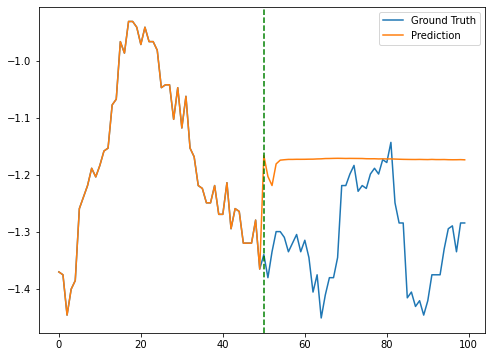

In [182]:
idx = 9
# plot graph
y_ground = np.concatenate((input_batch[idx].reshape(-1), target_batch[idx].reshape(-1)), 0)
model.eval()
hidden = torch.zeros(num_layers, 1, n_hidden)
y_pred = model(input_batch[idx].unsqueeze(0), hidden, input_batch[idx].unsqueeze(0))[0].detach().numpy().reshape(-1)
y_pred = np.concatenate((input_batch[idx].reshape(-1), y_pred), 0)

# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_ground, label='Ground Truth')
ax.plot(y_pred, label='Prediction')
# plt add v line at 50 
ax.axvline(50, color='green', linestyle='--')
ax.legend()
plt.show()

Connection made succ
[(15521, 'Stock', 'DKK', 'Danske Bank A/S', 'CSE', '1577', 'DK', '15521', 'Instrument', 'DANSKE:xcse', 'UNKNOWN'), (15611, 'Stock', 'DKK', 'Vestas Wind Systems A/S', 'CSE', '1548', 'DK', '15611', 'Instrument', 'VWS:xcse', 'UNKNOWN')]


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


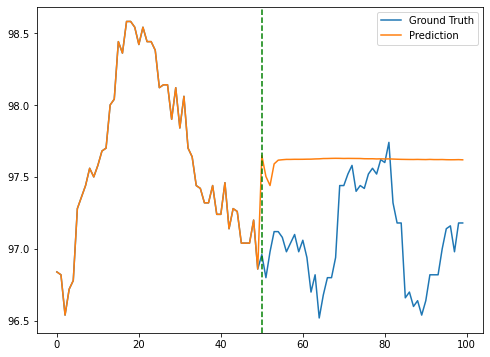

In [183]:
closingData = GetSingleStockDF()[1][:1000].values
# re scale data
y_ground = (y_ground * closingData.std()) + closingData.mean()
y_pred = (y_pred * closingData.std()) + closingData.mean()
# plot graph
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(y_ground, label='Ground Truth')
ax.plot(y_pred, label='Prediction')
# plt add v line at 50
ax.axvline(50, color='green', linestyle='--')
ax.legend()
plt.show()

In [162]:
closingData.mean(), closingData.var()


(261.3682, 9.121928760000003)

In [169]:
df = GetDF()
df

Connection made succ


,id,identifier,close,high,interest,low,open,time,volume
0,282624,15611,263.20,263.20,0.0,263.10,263.20,2021-09-06 10:34:00,1158.000000
1,282625,15611,263.00,263.10,0.0,263.00,263.10,2021-09-06 10:35:00,1745.000000
2,282626,15611,263.00,263.00,0.0,262.90,262.90,2021-09-06 10:36:00,240.000000
3,282627,15611,262.90,262.90,0.0,262.90,262.90,2021-09-06 10:37:00,7.000000
4,282628,15611,263.10,263.10,0.0,263.00,263.00,2021-09-06 10:38:00,223.000000
...,...,...,...,...,...,...,...,...,...
230560,448159,15611,103.20,103.40,0.0,103.16,103.32,2020-03-20 09:02:00,10224.999848
230561,448160,15611,103.12,103.16,0.0,102.96,103.16,2020-03-20 09:03:00,9834.999853
230562,448161,15611,102.80,103.04,0.0,102.80,103.04,2020-03-20 09:04:00,11964.999822
230563,448162,15611,102.20,102.76,0.0,102.12,102.76,2020-03-20 09:05:00,14229.999788


Connection made succ
[(15521, 'Stock', 'DKK', 'Danske Bank A/S', 'CSE', '1577', 'DK', '15521', 'Instrument', 'DANSKE:xcse', 'UNKNOWN'), (15611, 'Stock', 'DKK', 'Vestas Wind Systems A/S', 'CSE', '1548', 'DK', '15611', 'Instrument', 'VWS:xcse', 'UNKNOWN')]


C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Jeppe\Stonk\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


[         close
 0       114.65
 1       114.70
 2       114.70
 3       114.45
 4       114.40
 ...        ...
 219131   76.30
 219132   76.32
 219133   76.14
 219134   75.84
 219135   76.14
 
 [219136 rows x 1 columns],
          close
 0       263.20
 1       263.00
 2       263.00
 3       262.90
 4       263.10
 ...        ...
 230560  103.20
 230561  103.12
 230562  102.80
 230563  102.20
 230564  101.76
 
 [230565 rows x 1 columns]]

In [73]:
enc_outputs = torch.rand(n_step, batch_size, n_hidden)
dec_outputs = torch.rand(n_step, batch_size, n_hidden)
enc_outputs = enc_outputs.transpose(0, 1)
dec_outputs = dec_outputs.transpose(0, 1)
enc_outputs.shape, dec_outputs.shape

(torch.Size([10, 50, 128]), torch.Size([10, 50, 128]))

In [74]:
enc_outputs = torch.nn.functional.linear(enc_outputs, torch.rand(n_hidden, n_hidden))
enc_outputs.shape

torch.Size([10, 50, 128])

In [75]:
enc_outputs = enc_outputs.transpose(1,2)
dec_outputs.shape, enc_outputs.shape

(torch.Size([10, 50, 128]), torch.Size([10, 128, 50]))

In [91]:
attention_weights = torch.nn.functional.softmax(torch.bmm(dec_outputs, enc_outputs), dim=-1)
attention_weights.shape, enc_outputs.shape
enc_outputs = enc_outputs.transpose(1,2)
torch.bmm(attention_weights, enc_outputs).shape

torch.Size([10, 50, 128])

In [28]:
input_batch.unsqueeze(-1).shape

torch.Size([10, 50, 1])

In [24]:
output_batch == target_batch

tensor([[[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False,  True, False,
          False, False, False, False, False, False, False, False, False, False,
           True, False, False, False,  True,  True, False, False,  True,  True],
         [False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, 